In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
# import normflows as nf
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from fab import FABModel, HamiltonianMonteCarlo, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import SimpleBuffer
from torch.autograd import grad
from fab.utils.plotting import plot_contours, plot_marginal_pair
from experiments.make_flow import make_wrapped_normflow_realnvp
import models.ddpm
import models.mlp
import pdb
from tqdm import tqdm
from models.ddpm import GaussianDiffusion, TMLP
from models.mlp import MyMLP, SpectralNormMLP

import torch
import torchsde

from functorch import vmap

from torchdiffeq import odeint

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
str(device)

'cpu'

### Target Distribution

cpu False


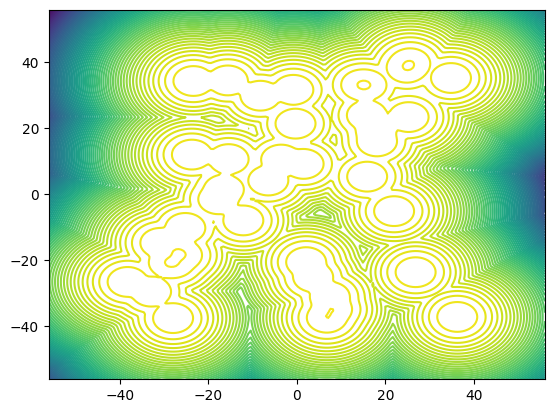

In [5]:
dim = 2
n_mixes = 40
loc_scaling = 40.0  # scale of the problem (changes how far apart the modes of each Guassian component will be)
log_var_scaling = 1.0  # variance of each Gaussian
seed = 0


if str(device) == "cpu":
    use_gpu = False
else:
    use_gpu = True
print(device, use_gpu)
torch.manual_seed(0)  # seed of 0 for GMM problem
target = GMM(
    dim=dim,
    n_mixes=n_mixes,
    loc_scaling=loc_scaling,
    log_var_scaling=log_var_scaling,
    use_gpu=use_gpu,
    true_expectation_estimation_n_samples=int(1e5),
)
# plot target
target.to("cpu")
fig, ax = plt.subplots()
plotting_bounds = (-loc_scaling * 1.4, loc_scaling * 1.4)
plot_contours(
    target.log_prob,
    bounds=plotting_bounds,
    n_contour_levels=80,
    ax=ax,
    grid_width_n_points=200,
)
target.to(device)

### Helper Functions

In [6]:
def plot_dataset(samples, gen_samples=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    target.to("cpu")
    plot_contours(
        target.log_prob,
        bounds=plotting_bounds,
        ax=axs[0],
        n_contour_levels=50,
        grid_width_n_points=200,
    )

    # plot dataset samples
    plot_marginal_pair(samples, ax=axs[0], bounds=plotting_bounds)
    axs[0].set_title("Buffer")

    if gen_samples is not None:
        plot_contours(
            target.log_prob,
            bounds=plotting_bounds,
            ax=axs[1],
            n_contour_levels=50,
            grid_width_n_points=200,
        )
        # plot generated samples
        plot_marginal_pair(gen_samples, ax=axs[1], bounds=plotting_bounds)
        axs[1].set_title("Generated samples")

    else:
        # delete subplot
        fig.delaxes(axs[1])

    target.to(device)
    plt.show()
    return [fig]

In [7]:
def normalize(x):
    # """
    # normalizes to [-1, 1]
    # """
    # mins = -50  # torch.min(x, dim=0)[0]
    # maxs = 50  # torch.max(x, dim=0)[0]
    # ## [ 0, 1 ]
    # x = (x - mins) / (maxs - mins + 1e-5)
    # ## [ -1, 1 ]
    # x = x * 2 - 1
    return x, 1, -1

    # return x, mins, maxs


def unnormalize(x, mins, maxs):
    # """
    # x : [ -1, 1 ]
    # """
    # # assert x.max() <= 1 and x.min() >= -1, f'x range: ({x.min():.4f}, {x.max():.4f})'
    # # x = x * std + mean
    # x = (x + 1) / 2
    # return x * (maxs - mins) + mins
    return x

## Function Definitions

### Estimated Reward Functions

In [8]:
# calculate the log expectation of the reward
def log_E_R(
    _x, _t, beta, num_mc_samples, global_mins=-50, global_maxs=50, var_exploding=True
):
    h_t = beta * _t.repeat_interleave(num_mc_samples).unsqueeze(1)
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    h_t = beta * repeated_t
    h_t = h_t.unsqueeze(1)
    if var_exploding:
        # variance exploding
        samples = repeated_x + torch.randn(repeated_x.shape).to(device) * (h_t**0.5)
        log_rewards = target.log_prob(unnormalize(samples, global_mins, global_maxs))
        log_expectation_R = torch.logsumexp(log_rewards, dim=-1) - np.log(
            num_mc_samples
        )
    else:
        # variance preserving
        samples = repeated_x / torch.sqrt(1 - repeated_t.unsqueeze(1)) + torch.randn(
            repeated_x.shape
        ).to(device) * (h_t**0.5)
        log_rewards = target.log_prob(unnormalize(samples, global_mins, global_maxs))
        log_expectation_R = (
            torch.log(1 / (1 - _t))
            + torch.logsumexp(log_rewards, dim=-1)
            - np.log(num_mc_samples)
        )
    return log_expectation_R

In [9]:
def estimated_Rt(x, t, beta, num_mc_samples=100, var_exploding=True):
    t = t * torch.ones(x.shape[0]).to(device)
    return torch.vmap(log_E_R, randomness="different", in_dims=(0, 0, None, None))(
        x, t, beta, num_mc_samples, var_exploding=var_exploding
    )

In [10]:
# def estimate_grad_Rt(x, t, beta, num_mc_samples=100, var_exploding=True, richardson=False):
#     t = t * torch.ones(x.shape[0]).to(device)
#     est_scores_n = torch.vmap(torch.func.grad(log_E_R),
#                             in_dims=(0,0,None,None), randomness='different')(x, t, beta, num_mc_samples,
#                                                                                   var_exploding=var_exploding)
#     if richardson:
#         est_scores_n_div2 = torch.vmap(torch.func.grad(log_E_R),
#                                    in_dims=(0,0,None,None), randomness='different')(x, t, beta, num_mc_samples//2,
#                                                                                          var_exploding=var_exploding)
#         return (2*est_scores_n - est_scores_n_div2)
#     else:
#         return est_scores_n

In [11]:
def estimate_grad_Rt(
    x, t, beta, num_mc_samples=100, var_exploding=True, richardson=False
):
    est_scores_n = torch.func.grad(log_E_R)(
        x, t, beta, num_mc_samples, var_exploding=var_exploding
    )
    if richardson:
        est_scores_n_div2 = torch.func.grad(log_E_R)(
            x, t, beta, num_mc_samples // 2, var_exploding=var_exploding
        )
        return 2 * est_scores_n - est_scores_n_div2
    else:
        return est_scores_n

### True Reward Functions

In [12]:
def true_Rt(x, t, beta, global_mins=-50, global_maxs=50, var_exploding=True):
    h_t = beta * t
    # target.convolve(h_t * (global_maxs**2), t, var_exploding=var_exploding)
    target.convolve(h_t, t, var_exploding=var_exploding)
    energy = target.log_prob(unnormalize(x, global_mins, global_maxs))
    target.reset()
    return energy

In [13]:
def true_grad_Rt(x, t, beta, var_exploding=True):
    samples_energy = true_Rt(x, t, beta, var_exploding=var_exploding)
    true_scores = torch.autograd.grad(samples_energy.sum(), x, retain_graph=True)[
        0
    ].detach()
    return true_scores

In [14]:
def score_multi_gaussian(
    x, t, beta, global_mins=-50, global_maxs=50, var_exploding=True
):
    h_t = beta * t
    # target.convolve(h_t * (global_maxs**2), t, var_exploding=var_exploding)
    target.convolve(h_t, t, var_exploding=var_exploding)
    sigma = target.scale_trils[:, 0, 0]
    mu = target.locs
    # s = torch.mean((x[:, None] - mu) / (sigma[:, None]**2), dim=1)
    s = -torch.mean((x - mu) / (sigma[:, None] ** 2), dim=0)
    target.reset()
    return s

# Testing

## SDE Tests

### Dataset

In [15]:
# hyper-parameters

# Flow
n_flow_layers = 15
layer_nodes_per_dim = 40
lr = 1e-4
max_gradient_norm = 100.0
batch_size = 128
n_iterations = 4000
n_eval = 10
eval_batch_size = batch_size * 10
n_plots = 10  # number of plots shows throughout tranining
use_64_bit = True
alpha = 2.0
num_samples = 10000

flow = make_wrapped_normflow_realnvp(
    dim,
    n_flow_layers=n_flow_layers,
    layer_nodes_per_dim=layer_nodes_per_dim,
    act_norm=False,
)

/home/mila/a/alexander.tong/.conda/envs/trajectory-inference/lib/python3.10/site-packages/torch/_tensor.py:663: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1915.)
  LU, pivots, infos = torch._lu_with_info(


In [16]:
# normalize the dataset
init_num_samples = 2048
unnorm_true_samples = (
    target.sample(torch.tensor(init_num_samples).unsqueeze(0)).to(device).detach()
)
unnorm_init_samples = flow.sample((init_num_samples,)).to(device).detach()
init_energy = target.log_prob(unnorm_init_samples).detach()
init_samples, global_mins_init, global_maxs_init = normalize(unnorm_init_samples)

global_mins_init = -50
global_maxs_init = 50

init_dataset = TensorDataset(init_samples, init_energy)
init_loader = DataLoader(init_dataset, batch_size=512, shuffle=True)

In [17]:
unnorm_true_test_samples = (
    target.sample(torch.tensor(init_num_samples).unsqueeze(0)).to(device).detach()
)

In [18]:
target.log_prob(unnorm_true_samples).detach().mean()

tensor(-6.8573)

In [19]:
target.log_prob(unnorm_true_test_samples).detach().mean()

tensor(-6.8641)

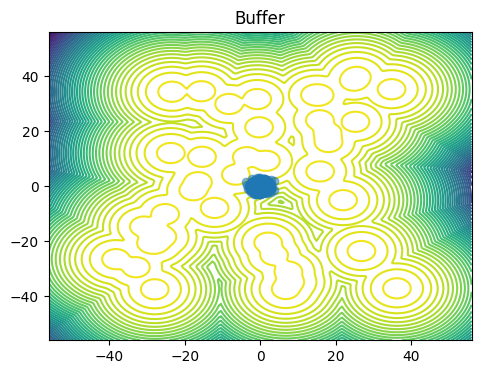

In [20]:
plot_dataset(unnorm_init_samples)  # visualise the initial samples
plt.show()

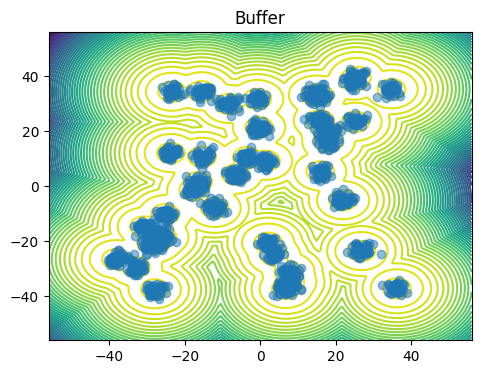

In [21]:
plot_dataset(unnorm_true_samples)  # visualise the initial samples
plt.show()

/home/mila/a/alexander.tong/.conda/envs/trajectory-inference/lib/python3.10/site-packages/lightning_utilities/core/imports.py:93: UserWarning: Unbuilt egg for MIOFlow [unknown version] (/home/mila/a/alexander.tong/MIOFlow)
  pkg_resources.require(self.requirement)


5000: loss 388.287 time 8.82


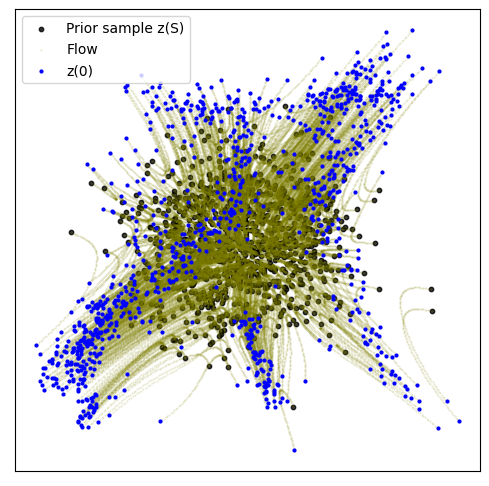

10000: loss 306.962 time 10.14


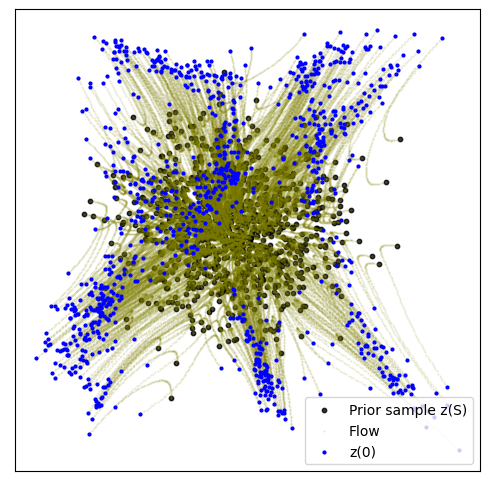

15000: loss 342.785 time 9.53


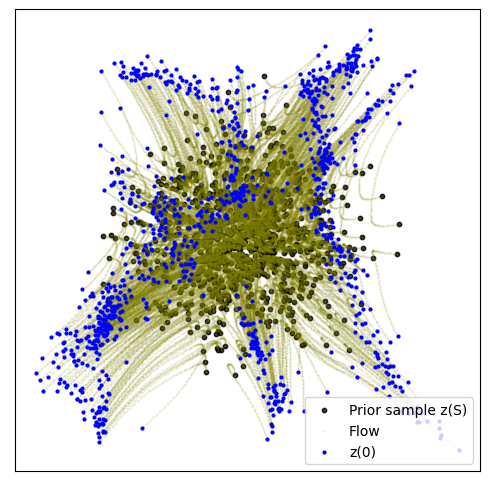

20000: loss 301.792 time 9.53


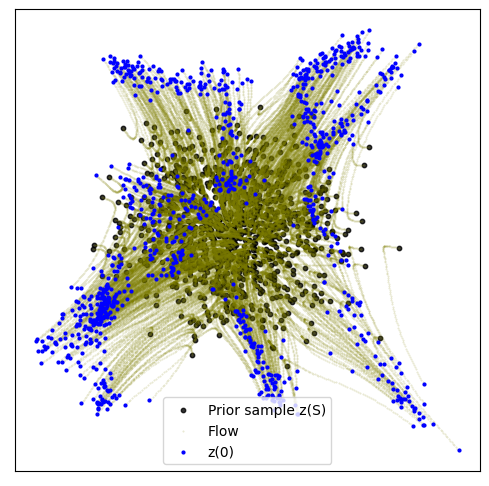

25000: loss 291.912 time 9.60


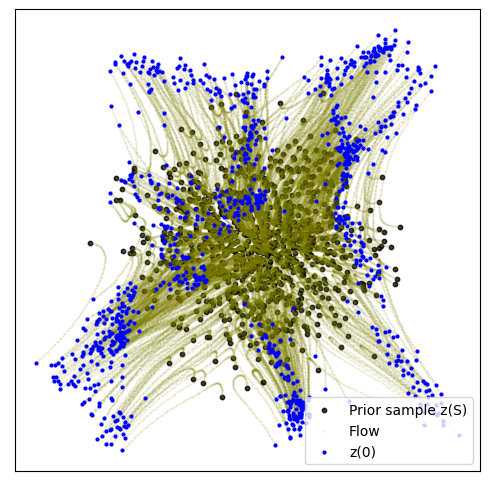

30000: loss 299.332 time 9.06


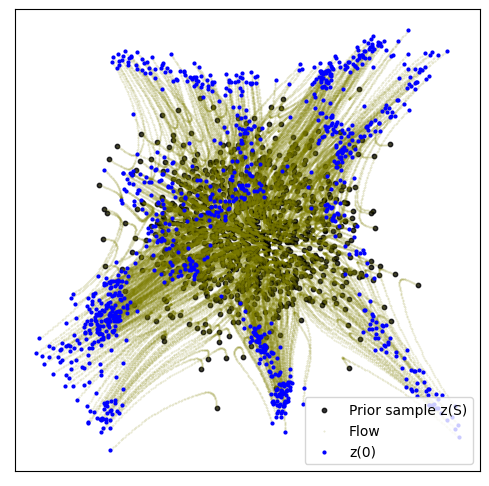

CPU times: user 2min 59s, sys: 4.88 s, total: 3min 4s
Wall time: 1min 3s


In [22]:
%%time
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *

sigma = 0.0
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
FM = ConditionalFlowMatcher(sigma=sigma)

start = time.time()
for k in range(30000):
    optimizer.zero_grad()

    x0 = torch.randn(batch_size, dim) * 10
    perm = torch.randperm(unnorm_true_samples.shape[0])
    idx = perm[:batch_size]
    x1 = unnorm_true_samples[idx]
    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model),
            solver="dopri5",
            sensitivity="adjoint",
            atol=1e-4,
            rtol=1e-4,
        )
        with torch.no_grad():
            traj = node.trajectory(
                torch.randn(1024, 2) * 10,
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())

In [30]:
!pip install functorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 5.6 MB/s eta 0:00:0000:0100:01
  Using cached nvidia_cufft_cu11-10.9.0.58-py3-none-manylinux1_x86_64.whl (168.4 MB)
  Using cached nvidia_cusolver_cu11-11.4.0.1-2-py3-none-manylinux1_x86_64.whl (102.6 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 12.1 MB/s eta 0:00:0000:0100:01
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl (317.1 MB)
  Using cached nvidia_curand_cu11-10.2.10.91-py3-none-manylinux1_x86_64.whl (54.6 MB)
  Using cached nvidia_cuda_cupti_cu11-11.7.101-py3-none-manylinux1_x86_64.whl (11.8 MB)
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl (557.1 MB)
  Using cached nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl (849 kB)
  Using cached nvidia_nvtx_cu11-11.7.91-py3-none-manylinux1_x86_64.whl (98 kB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl

In [53]:
import functorch


def div_fn(u):
    """Accepts a function u:R^D -> R^D."""
    J = functorch.jacrev(u)

    def log_change_of_variables(x):
        # print(x.shape)
        # print(J(x.unsqueeze(0)).shape)
        return torch.trace(J(x.unsqueeze(0)).squeeze())

    return log_change_of_variables


def output_and_div(vecfield, x):
    dx = vecfield(x)
    return dx, functorch.vmap(div_fn(vecfield), randomness="different")(
        x.clone().detach().requires_grad_(True)
    )


def log_prob_gaussian(x):
    dist = torch.distributions.MultivariateNormal(
        torch.zeros(2).to(device), torch.eye(2).to(device) * beta
    )
    return dist.log_prob(x)


def odefunc(t, x_in):
    x = x_in[..., :-1].clone().detach().requires_grad_(True)
    t = t.to(device)
    vecfield = lambda x: torch_wrapper(model)(t, x)
    dx, div = output_and_div(vecfield, x)
    div = div.reshape(-1, 1)
    return torch.cat([dx, div], dim=-1)


with torch.no_grad():
    x1, _, _ = normalize(unnorm_true_samples)
    state1 = torch.cat([x1, torch.zeros_like(x1[..., :1])], dim=-1)
    state1.requires_grad = True
    state0 = odeint(
        odefunc, state1, t=torch.linspace(1, 0, 1000).to(device), method="euler"
    )[-1]

    x0, logdetjac = state0[..., :-1], state0[..., -1]
    # logp0 = log_prob_gaussian(x0)
    # logp1 = -(logp0 - logdetjac)

In [54]:
x0

tensor([[20.6401, 13.0892],
        [-7.2595, -9.7960],
        [12.1009, 14.4293],
        ...,
        [-0.9357, -0.1677],
        [ 8.3224, -4.4718],
        [ 0.2097,  1.4227]])

In [55]:
logdetjac

tensor([ 1.5014,  0.6431,  1.9149,  ..., -0.3659, -1.1259, -0.1524])

In [56]:
logp0

tensor([-24.5158, -19.4597, -21.8339,  ...,  -7.8794, -12.3620, -10.1731])

In [57]:
beta = 100

In [58]:
logp0 = log_prob_gaussian(x0)

In [59]:
logp0

tensor([-9.4298, -7.1864, -8.2162,  ..., -6.4476, -6.8893, -6.4534])

In [60]:
logp1 = -(logp0 - logdetjac)

In [61]:
logp1.mean()

tensor(7.6887)

In [62]:
logp0.mean()

tensor(-7.5074)

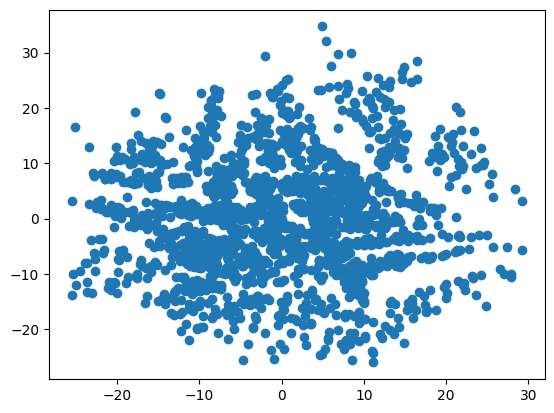

In [63]:
plt.scatter(x0[:, 0], x0[:, 1])

In [64]:
def get_likelihoods(test_data):
    with torch.no_grad():
        x0 = node.trajectory(
            torch.cat(
                [
                    torch.zeros((test_data.shape[0], 1)),
                    test_data.reshape(-1, 2),
                ],
                dim=1,
            ),
            t_span=torch.linspace(1, 0, 101),
        )
        # print(x0[:, :, 0])
        log_change_of_variables = x0[-1, :, 0]

        x0 = x0[-1, :, 1:].reshape(-1, dim)

        prior_prob = dist.log_prob(x0)
        log_prob_x1 = prior_prob - log_change_of_variables
        nll = -(prior_prob - log_change_of_variables)
        print(
            prior_prob.mean(),
            log_change_of_variables.mean(),
            log_prob_x1.mean(),
            nll.mean(),
        )
        return log_prob_x1, x0

In [65]:
dist = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2) * 10**2)

In [69]:
amodel = AugmentedVectorField(torch_wrapper(model), [CNFReg("exact")], dim=(2,))
from torchdyn.core import NeuralODE

node = NeuralODE(amodel, solver="euler")
p_data, x0 = get_likelihoods(unnorm_true_test_samples)

tensor(-7.4925) tensor(-0.1205) tensor(-7.3720) tensor(7.3720)


In [154]:
p_data, x0 = get_likelihoods(unnorm_true_test_samples + torch.randn(2048, 2) * 0)

tensor(-7.4463) tensor(-0.2118) tensor(-7.2345) tensor(7.2345)


In [134]:
x0.mean(), x0.std()

(tensor(-0.1507), tensor(10.0204))

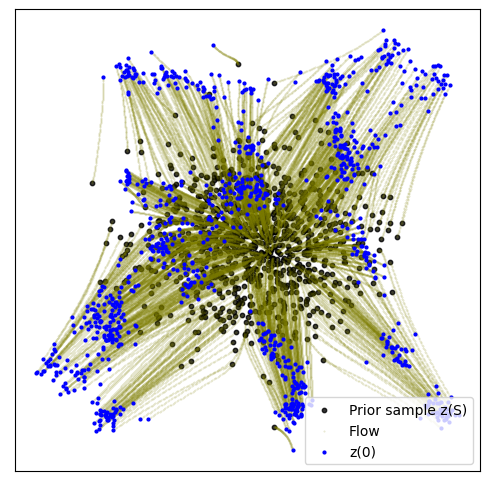

In [118]:
node = NeuralODE(
    torch_wrapper(model),
    solver="dopri5",
    sensitivity="adjoint",
    atol=1e-4,
    rtol=1e-4,
)
with torch.no_grad():
    traj = node.trajectory(
        torch.randn(1024, 2) * 10,
        t_span=torch.linspace(0, 1, 100),
    )
    plot_trajectories(traj.cpu().numpy())

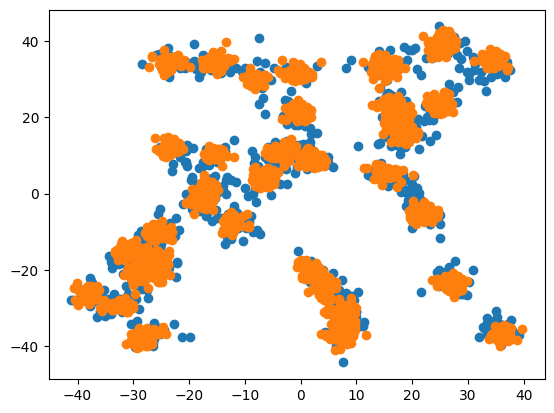

In [122]:
plt.scatter(traj.cpu().numpy()[-1, :, 0], traj.cpu().numpy()[-1, :, 1])
plt.scatter(unnorm_true_samples[:, 0], unnorm_true_samples[:, 1])

In [67]:
from torch import nn


class RegularizationFunc(nn.Module):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        """Outputs a batch of scaler regularizations."""
        raise NotImplementedError


def autograd_trace(x_out, x_in, **kwargs):
    """Standard brute-force means of obtaining trace of the Jacobian, O(d) calls to autograd."""
    trJ = 0.0
    # print("xin requires grad", x_in.requires_grad, x_out.requires_grad)
    for i in range(x_in.shape[1]):
        trJ += torch.autograd.grad(
            x_out[:, i].sum(), x_in, allow_unused=False, create_graph=True
        )[0][:, i]
    return trJ


class AugmentationModule(nn.Module):
    """Class orchestrating augmentations.

    Also establishes order.
    """

    def __init__(
        self,
        cnf_estimator: str = None,
        l1_reg: float = 0.0,
        l2_reg: float = 0.0,
        squared_l2_reg: float = 0.0,
        jacobian_frobenius_reg: float = 0.0,
        jacobian_diag_frobenius_reg: float = 0.0,
        jacobian_off_diag_frobenius_reg: float = 0.0,
    ) -> None:
        super().__init__()
        self.cnf_estimator = cnf_estimator
        names = []
        coeffs = []
        regs = []
        if cnf_estimator == "exact":
            names.append("log_prob")
            coeffs.append(1)
            regs.append(CNFReg(None, noise_dist=None))
        if l1_reg > 0.0:
            names.append("L1")
            coeffs.append(l1_reg)
            regs.append(L1Reg())
        if l2_reg > 0.0:
            names.append("L2")
            coeffs.append(l2_reg)
            regs.append(L2Reg())
        if squared_l2_reg > 0.0:
            names.append("squared_L2")
            coeffs.append(squared_l2_reg)
            regs.append(SquaredL2Reg())
        if jacobian_frobenius_reg > 0.0:
            names.append("jacobian_frobenius")
            coeffs.append(jacobian_frobenius_reg)
            regs.append(JacobianFrobeniusReg())
        if jacobian_diag_frobenius_reg > 0.0:
            names.append("jacobian_diag_frobenius")
            coeffs.append(jacobian_diag_frobenius_reg)
            regs.append(JacobianDiagFrobeniusReg())
        if jacobian_off_diag_frobenius_reg > 0.0:
            names.append("jacobian_off_diag_frobenius")
            coeffs.append(jacobian_off_diag_frobenius_reg)
            regs.append(JacobianOffDiagFrobeniusReg())
        self.names = names
        self.coeffs = torch.tensor(coeffs)
        self.regs = torch.nn.ModuleList(regs)
        assert len(self.coeffs) == len(self.regs)
        self.aug_dims = len(self.coeffs)
        self.augmenter = Augmenter(augment_idx=1, augment_dims=self.aug_dims)

    def forward(self, x):
        """Separates and adds together losses."""
        # if x.dim() > 2:
        # augmentation is broken, return regs = 0 for now
        #   reg = torch.zeros(1).type_as(x)
        #    return reg, x
        if self.cnf_estimator is None:
            if self.aug_dims == 0:
                reg = torch.zeros(1).type_as(x)
            else:
                aug, x = x[:, : self.aug_dims], x[:, self.aug_dims :]
                reg = aug * self.coeffs
            return reg, x
        delta_logprob, aug, x = x[:, :1], x[:, 1 : self.aug_dims], x[:, self.aug_dims :]
        reg = aug * self.coeffs[1:].to(aug)
        if self.aug_dims == 1:
            reg = torch.zeros(1).type_as(x)
        return delta_logprob, reg, x


def hutch_trace(x_out, x_in, noise=None, **kwargs):
    """Hutchinson's trace Jacobian estimator, O(1) call to autograd."""
    noise = torch.randn_like(x_in)
    jvp = torch.autograd.grad(x_out, x_in, noise, create_graph=True)[0]
    trJ = torch.einsum("bi,bi->b", jvp, noise)
    return trJ


class CNFReg(RegularizationFunc):
    def __init__(self, trace_estimator=None, noise_dist=None):
        super().__init__()
        self.trace_estimator = autograd_trace
        if trace_estimator == "hutch":
            self.trace_estimator = hutch_trace
        self.noise_dist, self.noise = noise_dist, None

    def forward(self, t, x, dx, context):
        # TODO we could check if jac is in the context to speed up
        return -self.trace_estimator(dx, x)


class Augmenter(nn.Module):
    """Augmentation class. Can handle several types of augmentation strategies for Neural DEs.

    :param augment_dims: number of augmented dimensions to initialize
    :type augment_dims: int
    :param augment_idx: index of dimension to augment
    :type augment_idx: int
    :param augment_func: nn.Module applied to the input datasets of dimension `d` to determine the augmented initial condition of dimension `d + a`.
                        `a` is defined implicitly in `augment_func` e.g. augment_func=nn.Linear(2, 5) augments a 2 dimensional input with 3 additional dimensions.
    :type augment_func: nn.Module
    :param order: whether to augment before datasets [augmentation, x] or after [x, augmentation] along dimension `augment_idx`. Options: ('first', 'last')
    :type order: str
    """

    def __init__(
        self,
        augment_idx: int = 1,
        augment_dims: int = 5,
        augment_func=None,
        order="first",
    ):
        super().__init__()
        self.augment_dims, self.augment_idx, self.augment_func = (
            augment_dims,
            augment_idx,
            augment_func,
        )
        self.order = order

    def forward(self, x: torch.Tensor, ts: torch.Tensor):
        if not self.augment_func:
            x = x.reshape(x.shape[0], -1)
            new_dims = list(x.shape)
            new_dims[self.augment_idx] = self.augment_dims

            # if-else check for augmentation order
            if self.order == "first":
                x = torch.cat([torch.zeros(new_dims).to(x), x], self.augment_idx)
            else:
                x = torch.cat([x, torch.zeros(new_dims).to(x)], self.augment_idx)
        else:
            # if-else check for augmentation order
            if self.order == "first":
                x = torch.cat([self.augment_func(x).to(x), x], self.augment_idx)
            else:
                x = torch.cat([x, self.augment_func(x).to(x)], self.augment_idx)
        return x, ts


class AugmentedVectorField(nn.Module):
    """NeuralODE but augmented state.

    Preprends Augmentations to state for easy integration over time
    """

    def __init__(self, net, augmentation_list: nn.ModuleList, dim):
        super().__init__()
        self.net = net
        self.dim = dim
        self.augmentation_list = augmentation_list

    def forward(self, t, state, augmented_input=True, *args, **kwargs):
        n_aug = len(self.augmentation_list)

        class SharedContext:
            pass

        with torch.set_grad_enabled(True):
            # first dimensions reserved for augmentations
            x = state
            if augmented_input:
                x = x[:, n_aug:].requires_grad_(True)

            # the neural network will handle the data-dynamics here
            if isinstance(self.dim, int):
                dx = self.net(t, x.reshape(-1, self.dim))
            else:
                dx = self.net(t, x.reshape(-1, *self.dim))
            if n_aug == 0:
                return dx
            dx = dx.reshape(dx.shape[0], -1)
            # x_out = x_out.squeeze(dim=1)

            augs = [
                aug_fn(t, x, dx, SharedContext) for aug_fn in self.augmentation_list
            ]
            augs = torch.stack(augs, dim=1)
        # `+ 0*state` has the only purpose of connecting state[:, 0] to autograd graph
        return torch.cat([augs, dx], 1) + (0 * state if augmented_input else 0)


class CNF(AugmentedVectorField):
    def __init__(self, net, trace_estimator=None, noise_dist=None):
        cnf_reg = CNFReg(trace_estimator, noise_dist)
        super().__init__(net, [cnf_reg])

### VE SDE

In [41]:
class VEReverseSDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, score, beta):
        super().__init__()
        self.score = score
        self.beta = beta

    def f(self, t, x):
        with torch.enable_grad():
            x.requires_grad = True
            score = torch.vmap(
                self.score, in_dims=(0, None, None), randomness="different"
            )(x, (1 - t).to(device), self.beta)
            # score = self.score(x, (1 - t).to(device), self.beta)
        return self.g(t, x) ** 2 * score

    def g(self, t, x):
        return torch.full_like(x, self.beta**0.5)

In [42]:
def generate_samples(ve_reverse_sde, x_init):
    t = torch.linspace(0.001, 1.0, 500)
    with torch.no_grad():
        samples = torchsde.sdeint(ve_reverse_sde, x_init, t)
    return samples

In [43]:
num_samples = 400
beta = 0.2 * 50**2

target.convolve(torch.tensor(1000, device=torch.device("cpu")), 1)
x1_samples = target.sample((num_samples,))
target.reset()
x1_samples_normalized = normalize(x1_samples)[0]

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [284]:
# ve_reverse_sde = VEReverseSDE(true_grad_Rt, beta)
ve_reverse_sde = VEReverseSDE(estimate_grad_Rt, beta)
samples = generate_samples(ve_reverse_sde, x1_samples_normalized)

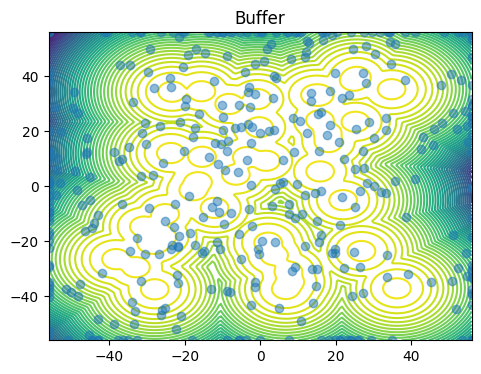

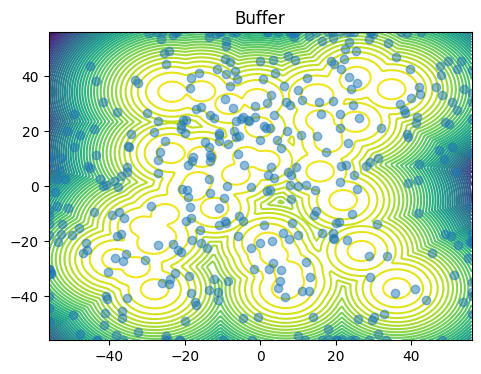

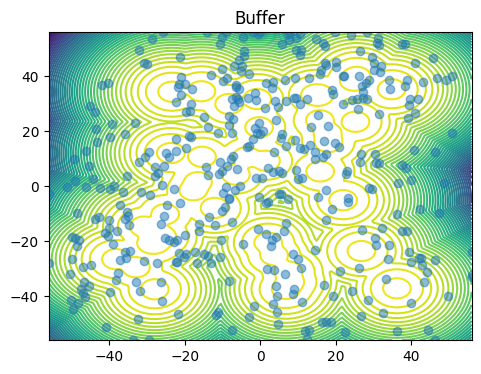

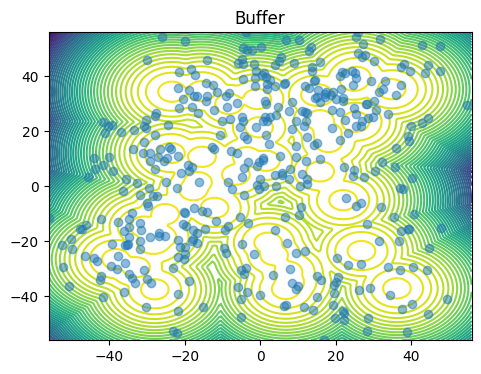

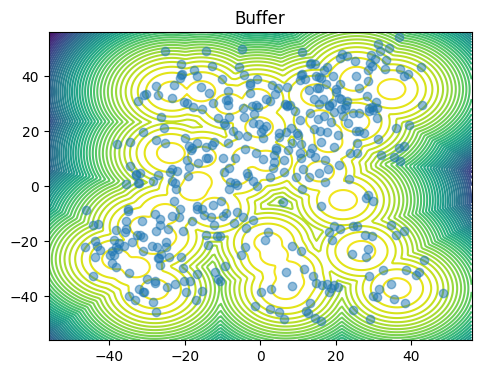

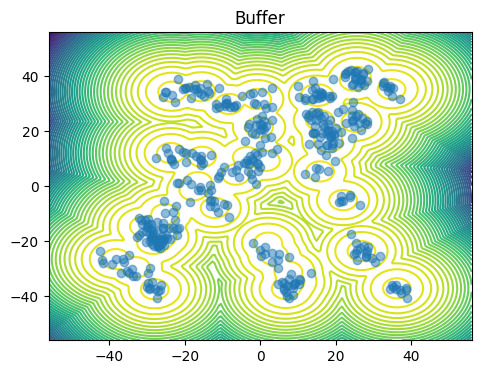

In [285]:
for i in range(0, 500, 99):
    plot_dataset(unnormalize(samples[i], global_mins_init, global_maxs_init))

In [38]:
beta = 1000 #1 * 50**2

In [32]:
from torch.func import jacrev

In [33]:
def drift(x, t):
    with torch.enable_grad():
        # s = torch.vmap(score_multi_gaussian, in_dims=(0, None, None))(x, t, beta)
        # f = 0.5 * beta * torch.vmap(score_multi_gaussian, in_dims=(0, None, None))(x, t, beta)
        # print(f)
        # f = 0.5 * beta * true_grad_Rt(x, t, beta)
        f = 0.5 * beta * estimate_grad_Rt(x, t, beta, num_mc_samples=100)
    return f

In [34]:
def div_fn(u):
    """Accepts a function u:R^D -> R^D."""
    J = jacrev(u)
    return lambda x: torch.trace(J(x))


def output_and_div(vecfield, x):
    dx = torch.vmap(vecfield, randomness="different")(x)
    return dx, torch.vmap(div_fn(vecfield), randomness="different")(x)

In [35]:
def log_prob_gaussian(x):
    dist = torch.distributions.MultivariateNormal(
        torch.zeros(2).to(device), torch.eye(2).to(device) * beta
    )
    return dist.log_prob(x)

In [39]:
def odefunc(t, x_in):
    x = x_in[..., :-1]
    t = t.to(device)
    vecfield = lambda x: drift(x, t)
    dx, div = output_and_div(vecfield, x)
    # dx = vecfield(x)
    # J = lambda x, t, beta: torch.trace(jacrev(score_multi_gaussian)(x, t, beta))
    # div = torch.vmap(J, in_dims=(0, None, None))(x, t, beta)
    div = div.reshape(-1, 1)
    return torch.cat([dx, div], dim=-1)


with torch.no_grad():
    x1, _, _ = normalize(unnorm_true_samples)
    state1 = torch.cat([x1, torch.zeros_like(x1[..., :1])], dim=-1)
    state1.requires_grad = True
    state0 = odeint(odefunc, state1, t=torch.linspace(0.01, 0.99, 100).to(device), method="euler")[-1]
    # state0 = euler_integrate(odefunc, state1, torch.linspace(0.01, 0.99, 100).to(device))
    x0, logdetjac = state0[..., :-1], state0[..., -1]
    #logp0 = log_prob_gaussian(x0)
    #logp1 = -(logp0 - logdetjac)

In [38]:
logdetjac

tensor([1.6434e-06, 1.6434e-06, 1.6434e-06,  ..., 1.6434e-06, 1.6434e-06,
        1.6434e-06], device='cuda:0', grad_fn=<SelectBackward0>)

In [39]:
a = true_Rt(x0, torch.tensor(0.99), beta) - logdetjac

In [260]:
logp1

tensor([86.5126, 87.1992, 87.3786,  ..., 82.3918, 85.4446, 88.4009],
       device='cuda:0', grad_fn=<MulBackward0>)

In [139]:
logdetjac.std()

tensor(2.9004, device='cuda:0')

In [140]:
logdetjac.mean()

tensor(-2.7579, device='cuda:0')

In [113]:
print(logp1.mean())
print(logp1.std())

tensor(4.2647, device='cuda:0')
tensor(38.6074, device='cuda:0')


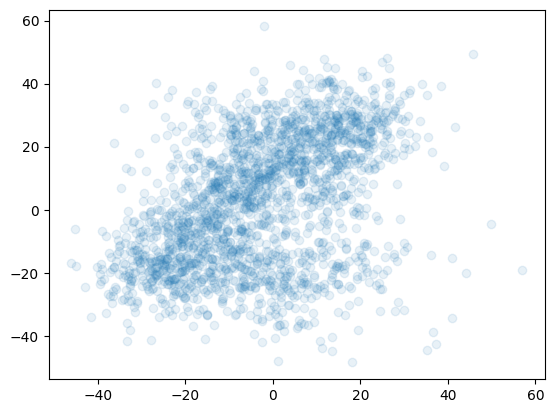

In [40]:
plt.scatter(x0[:, 0].detach().cpu(), x0[:, 1].detach().cpu(), alpha=0.1)

### VP SDE

In [ ]:
class VEReverseSDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, score, beta):
        super().__init__()
        self.score = score
        self.beta = beta

    def f(self, t, x):
        with torch.enable_grad():
            x.requires_grad = True
            score = self.score(x, 1 - t, self.beta)
        return self.g(t, x) ** 2 * score

    def g(self, t, x):
        return torch.full_like(x, self.beta**0.5)